# Transition Risk Analysis

## Objective
This script analyzes and projects Scope 1 and Scope 2 emissions for companies from 2025 to 2050, calculates carbon costs under different scenarios, evaluates abatement costs, and assesses tradeoffs between paying carbon prices and investing in abatement. The goal is to estimate future emissions paths and financial implications of carbon pricing for companies across various sectors and regions, using data from S&P Global.

## Key Functionalities
1. **Data Loading and Cleaning**:
   - Loads data from an Excel file containing emissions, reduction targets, abatement costs, and carbon prices.
   - Cleans data by standardizing column names, handling missing values, and correcting year formats.

2. **Emissions Projection**:
   - Projects Scope 1 and Scope 2 emissions to 2050 using absolute or intensity-based reduction targets.
   - Supports constant production or user-defined growth rates for intensity-based projections.

3. **Carbon Pricing Calculations**:
   - Computes carbon costs by multiplying projected emissions by scenario-specific carbon prices.
   - Includes a fallback to global carbon prices if region-specific prices are unavailable.
   - Aggregates abatement costs per company and calculates net savings from abatement vs. paying carbon costs.

4. **Visualization**:
   - Generates plots, including:
     - Stacked area chart of emissions by sector.
     - Heatmap of average carbon costs by scenario and year.
     - Waterfall chart comparing pay-only vs. abatement costs for a company.
     - Box plot of carbon cost distribution by country.
     - Scatter plot of abatement investment vs. net savings.
     - Carbon price projection curves for a sector and region.

## Data Requirements
- **Input File**: `S&P Global S1 Transition Risk Data.xlsx` with:
  - Table 1: Emissions data (uid, gics_sector, country, year, scope1_tonnes, scope2_tonnes, unit_production, production_volume).
  - Table 2: Reduction targets (uid, type_of_target, reduction_target, baseline, endline, etc.).
  - Table 3: Abatement costs (uid, abatement_cost_usd_year).
  - Table 4: Carbon prices (sector, region, year, scenario, carbon_price_usd_tco2e).
- **Dependencies**: `pandas`, `numpy`, `matplotlib`, `seaborn`, `openpyxl`.

## Usage
- Run the script directly (`transition_risk_analysis.py`) or in a Jupyter notebook.
- Ensure the Excel file is in the project directory.
- Install dependencies: `pip install pandas numpy matplotlib seaborn openpyxl`.

## Notes
- Missing values in emissions are imputed using median values by sector and size category.
- Carbon prices use region-specific values with a fallback to global prices.
- The script assumes a 0% production growth rate; adjust `production_growth_rate` in `project_emissions` if needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
streamlined_transition_risk_etl.py
----------------------------------
End-to-end ETL for the S&P Global S1 Transition-Risk workbook.

Outputs:
    df_emissions      – cleaned + imputed emissions (Table 1)
    df_targets_clean  – cleaned company targets (Table 2)
    df_abatement      – cleaned abatement catalogue (Table 3)
    df_carbon_prices  – cleaned carbon-price assumptions (Table 4)
    df_merged         – targets ⟷ emissions join, for modelling
"""

# ── Imports ─────────────────────────────────────────────────────────────────────
import re
import numpy as np
import pandas as pd
import seaborn as sns

# ── Global config ──────────────────────────────────────────────────────────────
sns.set(style="whitegrid")

FILE_PATH = "S&P Global S1 Transition Risk Data.xlsx"

YEAR_REPLACEMENTS = {"2,025": 2025, "202five": 2025}
COUNTRY_REPLACEMENTS = {"EUROPE": "EU", "Europa": "EU"}

# ── Helper functions ───────────────────────────────────────────────────────────
def clean_country_series(s: pd.Series) -> pd.Series:
    """Fill missing and harmonise EU shorthand."""
    return s.fillna("Unknown").replace(COUNTRY_REPLACEMENTS)


def clean_year_series(s: pd.Series) -> pd.Series:
    """Standardise year strings → integers."""
    s = s.replace(YEAR_REPLACEMENTS).astype(str).str.replace(",", "").str.strip()
    return pd.to_numeric(s, errors="coerce").astype("Int64")


def to_numeric_series(s: pd.Series, *, non_neg: bool = True) -> pd.Series:
    """Coerce to numeric, optionally clipping negatives."""
    s = pd.to_numeric(s, errors="coerce")
    return s.clip(lower=0) if non_neg else s


def impute_missing_emissions(df: pd.DataFrame, *, sector: str = "Materials") -> pd.DataFrame:
    """
    Fill NA scope-1 / scope-2 values for `sector` with size-bucket medians
    (buckets based on production-volume terciles).
    """
    full = df.copy()
    sect = full[full["gics_sector"] == sector]

    if sect[["scope1_tonnes", "scope2_tonnes"]].notna().all(axis=None):
        return full  # nothing to do

    lo, hi = sect["production_volume"].quantile([0.33, 0.66])

    def bucket(v):
        if pd.isna(v):
            return "Medium"
        if v <= lo:
            return "Small"
        if v <= hi:
            return "Medium"
        return "Large"

    sect = sect.assign(size_category=sect["production_volume"].apply(bucket))
    med = sect.groupby("size_category")[["scope1_tonnes", "scope2_tonnes"]].median()

    for col in ("scope1_tonnes", "scope2_tonnes"):
        na_idx = sect[sect[col].isna()].index
        for i in na_idx:
            full.loc[i, col] = med.loc[sect.at[i, "size_category"], col]

    return full

# ── Helper updates ─────────────────────────────────────────────────────────────
YEAR_WORDS = {
    "twenty-twenty": 2020,
    "twenty twenty": 2020,
    "2,024": 2024,
    "202four": 2024,
    "forty": 40,           # used in reduction parsing
}

def clean_year_word(val):
    """Handle words / commas → nullable int."""
    if pd.isna(val):
        return pd.NA
    txt = str(val).strip().lower().replace(",", "")
    if txt in YEAR_WORDS:
        return YEAR_WORDS[txt]
    return pd.to_numeric(txt, errors="coerce")



def split_reduction(val):
    """
    Parse `reduction_target` Free-text → (value, type, unit)
       • 40 %  → 0.40, 'absolute', '%'
       • 1.2 tCO2e/t           → intensity
       • unknown / non-parse   → NaNs
    """
    if pd.isna(val):
        return pd.Series([np.nan, "unknown", None])
    t = str(val).strip().lower()

    # exact patterns (e.g. "40%" or "forty%")
    if t in {"40%", "forty%"}:
        return pd.Series([0.40, "absolute", "%"])

    # explicit intensity strings
    m = re.match(r"([0-9]*\.?[0-9]+)\s*tco2e/?(.+)?", t)
    if m:
        num = float(m.group(1))
        unit = f"tCO2e/{m.group(2).strip()}" if m.group(2) else "tCO2e"
        return pd.Series([num, "intensity", unit])

    # other % entries
    if t.endswith("%"):
        try:
            num = float(t.replace("%", "")) / 100
            return pd.Series([num, "absolute", "%"])
        except ValueError:
            return pd.Series([np.nan, "absolute", "%"])

    # bare number
    try:
        num = float(t)
        num = num / 100 if num > 1 else num
        return pd.Series([num, "absolute", "%"])
    except ValueError:
        return pd.Series([np.nan, "unknown", None])


# ── ETL ────────────────────────────────────────────────────────────────────────
def run_etl(path: str = FILE_PATH):
    # ---- Load all sheets in one go ----
    sheets = pd.read_excel(path, sheet_name=None)
    raw_emissions = sheets["Table 1"]
    raw_targets   = sheets["Table 2"]
    raw_abatement = sheets["Table 3"]
    raw_prices    = sheets["Table 4"]

    # ---- Table 1 – Emissions ----
    df_em = raw_emissions.copy()
    df_em.columns = [
        "uid", "gics_sector", "country", "year",
        "scope1_tonnes", "scope2_tonnes",
        "unit_production", "production_volume",
    ]
    df_em = (
        df_em.drop_duplicates("uid")
             .assign(
                 country = clean_country_series(df_em["country"]),
                 year    = clean_year_series(df_em["year"]),
                 scope1_tonnes = to_numeric_series(df_em["scope1_tonnes"]),
                 scope2_tonnes = to_numeric_series(df_em["scope2_tonnes"]),
                 production_volume = pd.to_numeric(
                     df_em["production_volume"], errors="coerce"
                 ).fillna(0),
             )
    )
    df_em = impute_missing_emissions(df_em, sector="Materials")

        # ---- Table 2 – Targets --------------------------------------------------------
    df_t = raw_targets.copy()
    df_t.columns = [
        "uid", "type_of_target", "reduction_target",
        "baseline", "endline", "comment",
    ]

    # 1. clean years
    df_t["baseline_year"] = df_t["baseline"].apply(clean_year_word).astype("Int64")
    df_t["endline_year"]  = df_t["endline"].apply(clean_year_word).astype("Int64")
    df_t = df_t.drop(columns=["baseline", "endline"])

    # 2. parse reduction_target → value / type / unit
    df_t[["reduction_value", "reduction_type", "reduction_unit"]] = (
        df_t["reduction_target"].apply(split_reduction)
    )

    # 3. **NEW** hard filter: keep only rows that *have* a numeric value
    df_t = df_t.dropna(subset=["reduction_value"])

    # 4. cast to float once (pd.NA → np.nan is now impossible, but keeps dtype uniform)
    df_t["reduction_value"] = df_t["reduction_value"].astype(float)

    # 5. tidy + order
    df_targets_clean = (
        df_t[
            [
                "uid", "type_of_target", "reduction_target",
                "reduction_value", "reduction_type", "reduction_unit",
                "baseline_year", "endline_year", "comment",
            ]
        ]
        .sort_values(["uid", "type_of_target"])
        .reset_index(drop=True)
    )


    # ---- Table 3 – Abatement catalogue ----
    df_ab = raw_abatement.copy()
    df_ab.columns = [
        "sector", "region", "technology",
        "initial_investment_usd_million",
        "abatement_capacity_tco2e_year",
        "abatement_cost_usd_tco2e_year",
    ]
    df_ab["region"] = df_ab["region"].replace(COUNTRY_REPLACEMENTS)
    df_ab["abatement_cost_usd_tco2e_year"] = (
        df_ab["abatement_cost_usd_tco2e_year"]
              .replace({"eighty": 80})
              .astype(float)
    )
    df_ab["initial_investment_usd_million"] = (
        df_ab["initial_investment_usd_million"]
              .fillna(df_ab.groupby("sector")["initial_investment_usd_million"].transform("mean"))
    )

    # ---- Table 4 – Carbon prices ----
    df_cp = raw_prices.copy()
    df_cp.columns = ["sector", "region", "year", "scenario", "carbon_price_usd_tco2e"]
    df_cp["region"] = df_cp["region"].replace(COUNTRY_REPLACEMENTS)
    df_cp["carbon_price_usd_tco2e"] = (
        pd.to_numeric(df_cp["carbon_price_usd_tco2e"], errors="coerce")
          .fillna(df_cp.groupby("scenario")["carbon_price_usd_tco2e"].transform("median"))
    )

    # ---- Join targets ↔ emissions ----
    df_merged = (
        df_targets_clean
            .merge(df_em, on="uid", how="left", indicator=True)
            .rename(columns={"_merge": "merge_status"})
    )

    return df_em, df_targets_clean, df_ab, df_cp, df_merged


# ── Script entry-point ─────────────────────────────────────────────────────────
if __name__ == "__main__":
    # Enable pandas future warnings once for reproducibility
    pd.set_option("future.no_silent_downcasting", True)

    (
        df_emissions,
        df_targets_clean,
        df_abatement,
        df_carbon_prices,
        df_merged,
    ) = run_etl()

    # Quick sanity printout
    print(f"Emissions rows : {len(df_emissions):,}")
    print(f"Targets rows   : {len(df_targets_clean):,}")
    print(f"Abatement rows : {len(df_abatement):,}")
    print(f"Carbon price rows: {len(df_carbon_prices):,}")
    print(f"Merged rows    : {len(df_merged):,}")


Emissions rows : 50
Targets rows   : 50
Abatement rows : 60
Carbon price rows: 225
Merged rows    : 50


In [3]:
df_targets_clean.head()

,uid,type_of_target,reduction_target,reduction_value,reduction_type,reduction_unit,baseline_year,endline_year,comment
0,C001,Scope 2,0.547,0.547,absolute,%,2019,2050,NaN
1,C002,Scope 1,0.35 tCO2e/MWh,0.350,intensity,tCO2e/mwh,2020,2050,NaN
2,C003,Scope 1,0.348,0.348,absolute,%,2018,2050,NaN
3,C003,Scope 2,0.256,0.256,absolute,%,2019,2030,NaN
4,C004,Scope 2,0.188,0.188,absolute,%,2024,2050,NaN


In [4]:
df_merged.head()

,uid,type_of_target,reduction_target,reduction_value,reduction_type,reduction_unit,baseline_year,endline_year,comment,gics_sector,country,year,scope1_tonnes,scope2_tonnes,unit_production,production_volume,merge_status
0,C001,Scope 2,0.547,0.547,absolute,%,2019,2050,NaN,Real Estate,Global,2025,21510000.0,1070000.0,m2 building,46280000.0,both
1,C002,Scope 1,0.35 tCO2e/MWh,0.350,intensity,tCO2e/mwh,2020,2050,NaN,Energy,Brazil,2025,6570000.0,17510000.0,MWh,40950000.0,both
2,C003,Scope 1,0.348,0.348,absolute,%,2018,2050,NaN,Energy,EU,2025,19940000.0,7720000.0,MWh,69790000.0,both
3,C003,Scope 2,0.256,0.256,absolute,%,2019,2030,NaN,Energy,EU,2025,19940000.0,7720000.0,MWh,69790000.0,both
4,C004,Scope 2,0.188,0.188,absolute,%,2024,2050,NaN,Consumer Discretionary,Unknown,2025,13340000.0,17140000.0,unit,98870000.0,both


In [5]:
df_merged.query("uid == 'C026'").head()

,uid,type_of_target,reduction_target,reduction_value,reduction_type,reduction_unit,baseline_year,endline_year,comment,gics_sector,country,year,scope1_tonnes,scope2_tonnes,unit_production,production_volume,merge_status


In [6]:
df_targets_clean.query("uid == 'C026'").head()

,uid,type_of_target,reduction_target,reduction_value,reduction_type,reduction_unit,baseline_year,endline_year,comment


In [7]:
df_emissions.query("uid == 'C026'").head()

,uid,gics_sector,country,year,scope1_tonnes,scope2_tonnes,unit_production,production_volume
25,C026,Consumer Discretionary,USA,2025,25900000.0,1060000.0,unit,78590000.0


Merge Emissions and Targets dataframe and clean and standardize

In [ ]:
df_targets.head()

In [ ]:
df_targets_clean.head()

In [ ]:
df_merged.head()

In [ ]:
# filter for uid equal C011 
# df_filtered = df_merged[df_merged['uid'] == 'C011'].copy()

In [8]:


def project_emissions(
    row: pd.Series,
    years: np.ndarray = np.arange(2025, 2051),
    scenarios: dict | None = None,
    interpolation_method: str = "linear",
    *,
    targets_df: pd.DataFrame = df_targets_clean,   # injected once, stays global
) -> pd.DataFrame:
    """
    Project Scope-1 & Scope-2 emissions for ONE company, 2025-2050.

    Assumptions revised:
    • `scope1_tonnes`, `scope2_tonnes`, `baseline_production_volume`
      already represent the company’s *actual 2025* values.
    • No growth is applied to bring earlier-baseline figures up to 2025.
    • Reductions (absolute or intensity) start in 2026 or later.
    """
    # ───────────────────────────────────────────────────────────────
    # A.  Filter out Scope-3-only rows
    # ───────────────────────────────────────────────────────────────
    if "scope 3" in str(row.get("type_of_target", "")).lower():
        return pd.DataFrame()

    uid          = row["uid"]
    tgt_scope    = row["type_of_target"]            # "Scope 1" / "Scope 2" / "Direct"
    base_prod    = row.get("baseline_production_volume", 0)
    g_rate       = row.get("production_growth_rate", 0.0)

    # 2025 anchor tonnages (already correct and *static*)
    s1_2025 = row.get("scope1_tonnes")
    s2_2025 = row.get("scope2_tonnes")

    # ───────────────────────────────────────────────────────────────
    # B.  Fallbacks if 2025 tonnages are missing
    #     (copy baseline value *as-is* – NO growth)
    # ───────────────────────────────────────────────────────────────
    need_s1 = not tgt_scope.lower().startswith("scope 2")
    need_s2 = not tgt_scope.lower().startswith("scope 1")

    if pd.isna(s1_2025) and need_s1:
        s1_2025 = row.get("baseline_scope1_tonnes")
        if pd.isna(s1_2025) and base_prod > 0:
            s1_2025 = row.get("baseline_scope1_intensity") * base_prod

    if pd.isna(s2_2025) and need_s2:
        s2_2025 = row.get("baseline_scope2_tonnes")
        if pd.isna(s2_2025) and base_prod > 0:
            s2_2025 = row.get("baseline_scope2_intensity") * base_prod

    # must now have every required 2025 anchor
    if (need_s1 and pd.isna(s1_2025)) or (need_s2 and pd.isna(s2_2025)):
        raise ValueError(f"{uid}: missing 2025 Scope-1/2 values required for projection.")

    # replace unused scopes with zero
    s1_2025 = 0 if pd.isna(s1_2025) else float(s1_2025)
    s2_2025 = 0 if pd.isna(s2_2025) else float(s2_2025)

    # keep a true 2025 production anchor
    prod_2025 = float(base_prod)

    # ───────────────────────────────────────────────────────────────
    # C.  Pick this company’s targets (same uid + scope)
    # ───────────────────────────────────────────────────────────────
    tgt_mask = targets_df["uid"].eq(uid)
    if tgt_scope.lower().startswith("scope 1"):
        tgt_mask &= targets_df["type_of_target"].str.startswith("Scope 1")
    elif tgt_scope.lower().startswith("scope 2"):
        tgt_mask &= targets_df["type_of_target"].str.startswith("Scope 2")

    targets = (
        targets_df.loc[tgt_mask]
                  .dropna(subset=["reduction_value", "endline_year"])
                  .assign(endline_year=lambda d: d["endline_year"].astype(int))
                  .query("endline_year > 2025")
                  .copy()
    )

    # ───────────────────────────────────────────────────────────────
    # D.  Default scenario if none given
    # ───────────────────────────────────────────────────────────────
    if scenarios is None:
        scenarios = {"default": {"growth_rate": g_rate,
                                 "interpolation": interpolation_method}}

    # helper for absolute-reduction curves
    def _apply_absolute(base_val, reduction, n_years, yr, interp):
        tgt_val = base_val * (1 - reduction)
        drop    = base_val - tgt_val
        if interp == "linear":
            frac = min((yr - 2025) / n_years, 1)
            return base_val - drop * frac
        elif interp == "exponential":
            r = (1 - reduction) ** (1 / n_years)
            return base_val * r ** (yr - 2025) if yr <= 2025 + n_years else tgt_val
        elif interp == "s_curve":
            k  = 9.21 / n_years
            t0 = 2025 + n_years / 2
            frac = 1 / (1 + np.exp(-k * (yr - t0))) if yr <= 2025 + n_years else 1
            return base_val - drop * frac
        else:
            raise ValueError(f"Unknown interpolation '{interp}'")

    # ───────────────────────────────────────────────────────────────
    # E.  Build pathway rows
    # ───────────────────────────────────────────────────────────────
    rows = []

    for scen, cfg in scenarios.items():
        g_r   = cfg.get("growth_rate", g_rate)
        interp= cfg.get("interpolation", interpolation_method)

        for yr in years:
            s1, s2 = s1_2025, s2_2025     # reset every year

            # apply all targets that matter
            for _, tgt in targets.iterrows():
                nY = tgt["endline_year"] - 2025
                if nY <= 0:
                    continue

                red_val = tgt["reduction_value"]
                red_typ = tgt["reduction_type"]
                t_scope = tgt["type_of_target"]

                # ----- absolute reduction ----------------------------------
                if red_typ == "absolute":
                    if t_scope.startswith("Scope 1"):
                        s1 = _apply_absolute(s1_2025, red_val, nY, yr, interp)
                    elif t_scope.startswith("Scope 2"):
                        s2 = _apply_absolute(s2_2025, red_val, nY, yr, interp)
                    else:  # "Direct"
                        T0 = s1_2025 + s2_2025
                        Tt = _apply_absolute(T0, red_val, nY, yr, interp)
                        if T0:
                            s1 = Tt * s1_2025 / T0
                            s2 = Tt * s2_2025 / T0

                # ----- intensity reduction --------------------------------
                else:
                    if prod_2025 == 0:      # nothing to scale
                        continue
                    prod_yr = (
                        prod_2025 if yr == 2025
                        else prod_2025 * (1 + g_r) ** (yr - 2025)
                    )

                    def _apply_intensity(base_I):
                        return _apply_absolute(base_I, red_val, nY, yr, interp)

                    if t_scope.startswith("Scope 1"):
                        I0 = s1_2025 / prod_2025
                        s1 = _apply_intensity(I0) * prod_yr
                    elif t_scope.startswith("Scope 2"):
                        I0 = s2_2025 / prod_2025
                        s2 = _apply_intensity(I0) * prod_yr
                    else:
                        I0 = (s1_2025 + s2_2025) / prod_2025
                        It = _apply_intensity(I0) * prod_yr
                        frac = s1_2025 / (s1_2025 + s2_2025) if s1_2025 + s2_2025 else 0
                        s1, s2 = It * frac, It * (1 - frac)

            # what counts toward the company’s own KPI?
            if tgt_scope.lower().startswith("scope 1"):
                tgt_em = round(s1)
            elif tgt_scope.lower().startswith("scope 2"):
                tgt_em = round(s2)
            else:  # "Direct"
                tgt_em = round(s1 + s2)

            rows.append({
                "uid": uid,
                "gics_sector": row["gics_sector"],
                "country": row["country"],
                "type_of_target": tgt_scope,
                "year": yr,
                "scope1_tonnes": round(s1),
                "scope2_tonnes": round(s2),
                "targeted_emissions": tgt_em,
                "scenario": scen,
            })

    return pd.DataFrame(rows)


In [ ]:
df_merged.reduction_value.unique()

In [9]:
# Corrected scenarios dictionary
scenarios = {
    'low': {'growth_rate': 0.0, 'interpolation': 'linear'},
    'med': {'growth_rate': 0.01, 'interpolation': 'linear'},
    'high': {'growth_rate': 0.02, 'interpolation': 'linear'},
    # 's_curve_low': {'growth_rate': 0.0, 'interpolation': 's_curve'},
    # 's_curve_med': {'growth_rate': 0.01, 'interpolation': 's_curve'},
    # 's_curve_high': {'growth_rate': 0.02, 'interpolation': 's_curve'}
}

# Run the projection
# emissions_paths = project_emissions(df_merged, scenarios=scenarios)
# Apply the function and concatenate results
emissions_paths_list = df_merged.apply(
    lambda row: project_emissions(row, scenarios=scenarios), axis=1
).tolist()
emissions_paths = pd.concat(emissions_paths_list, ignore_index=True)

# Define mappings
growth_rate_mapping = {
    'low': 0.0,
    'med': 0.01,
    'high': 0.02,
    # 's_curve_low': 0.0,
    # 's_curve_med': 0.01,
    # 's_curve_high': 0.02
}

interpolation_mapping = {
    'low': 'linear',
    'med': 'linear',
    'high': 'linear',
    # 's_curve_low': 's_curve',
    # 's_curve_med': 's_curve',
    # 's_curve_high': 's_curve'
}

# Add columns
emissions_paths['growth_rate'] = emissions_paths['scenario'].map(growth_rate_mapping)
emissions_paths['interpolation_method'] = emissions_paths['scenario'].map(interpolation_mapping)



In [10]:
emissions_paths.head()

,uid,gics_sector,country,type_of_target,year,scope1_tonnes,scope2_tonnes,targeted_emissions,scenario,growth_rate,interpolation_method
0,C001,Real Estate,Global,Scope 2,2025,21510000,1070000,1070000,low,0.0,linear
1,C001,Real Estate,Global,Scope 2,2026,21510000,1046588,1046588,low,0.0,linear
2,C001,Real Estate,Global,Scope 2,2027,21510000,1023177,1023177,low,0.0,linear
3,C001,Real Estate,Global,Scope 2,2028,21510000,999765,999765,low,0.0,linear
4,C001,Real Estate,Global,Scope 2,2029,21510000,976354,976354,low,0.0,linear


In [11]:
#export the emissions_paths DataFrame to a CSV file
emissions_paths.to_csv("emissions_paths.csv", index=False)
# export df_merged to a CSV file
df_merged.to_csv("df_merged.csv", index=False)
# export df_emissions to a CSV file
df_emissions.to_csv("df_emissions.csv", index=False)
# export df_targets_clean to a CSV file
df_targets_clean.to_csv("df_targets_clean.csv", index=False)
# export df_abatement to a CSV file
df_abatement.to_csv("df_abatement.csv", index=False)
# export df_carbon_prices to a CSV file
df_carbon_prices.to_csv("df_carbon_prices.csv", index=False)

In [ ]:
emissions_paths.head()

In [ ]:
df_targets.head()

Estimate Carbon pricing

In [12]:
df_carbon_prices.head(5)

,sector,region,year,scenario,carbon_price_usd_tco2e
0,Energy,USA,2025,Low Risk,58.07
1,Energy,USA,2027,Low Risk,57.92
2,Energy,USA,2030,Low Risk,59.77
3,Energy,USA,2025,Medium Risk,55.26
4,Energy,USA,2027,Medium Risk,65.63


In [ ]:
df_carbon_prices.tail()

In [ ]:
ngf5_global_carbon_prices = pd.read_csv("/Users/tarunluthra/Documents/SPglobal/ngfs_global_snapshot_1750868451.csv")
ngf5_eu_carbon_prices = pd.read_csv("/Users/tarunluthra/Documents/SPglobal/ngfs_snapshot_1750868525.csv")

In [ ]:
ngf5_global_carbon_prices.head()

NGF5 and CAGR model for carbon pricing for different scenarios

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Define the function to project carbon prices using linear regression
def project_carbon_price(group):
    # Fill missing carbon prices with the median of the group
    group['carbon_price_usd_tco2e_filled'] = group['carbon_price_usd_tco2e'].fillna(group['carbon_price_usd_tco2e'].median())
    group_filled = group.dropna(subset=['carbon_price_usd_tco2e_filled'])
    if len(group_filled) >= 2:
        # Prepare data for linear regression
        X = group_filled['year'].values.reshape(-1, 1)
        y = group_filled['carbon_price_usd_tco2e_filled'].values
        model = LinearRegression()
        model.fit(X, y)
        # Predict prices from 2025 to 2050
        years = np.arange(2025, 2051)
        predictions = model.predict(years.reshape(-1, 1))
        return pd.DataFrame({'year': years, 'carbon_price_usd_tco2e': predictions})
    else:
        # Return NaN predictions if insufficient data
        years = np.arange(2025, 2051)
        return pd.DataFrame({'year': years, 'carbon_price_usd_tco2e': [np.nan] * len(years)})

# Assuming df_carbon_prices is a DataFrame with columns: sector, region, scenario, year, carbon_price_usd_tco2e
# Apply the projection to get carbon_prices_full
carbon_prices_full = df_carbon_prices.groupby(['sector', 'region', 'scenario']).apply(project_carbon_price).reset_index()
carbon_prices_full = carbon_prices_full.sort_values(by=['sector', 'region', 'scenario', 'year'])
# Export the projected carbon prices to a CSV file
carbon_prices_full.to_csv("projected_carbon_prices_full.csv", index=False)

/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_49547/46652308.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  carbon_prices_full = df_carbon_prices.groupby(['sector', 'region', 'scenario']).apply(project_carbon_price).reset_index()


In [17]:
carbon_prices_full.head()

,sector,region,scenario,level_3,year,carbon_price_usd_tco2e
0,Consumer Discretionary,China,High Risk,0,2025,9.527632
1,Consumer Discretionary,China,High Risk,1,2026,11.365789
2,Consumer Discretionary,China,High Risk,2,2027,13.203947
3,Consumer Discretionary,China,High Risk,3,2028,15.042105
4,Consumer Discretionary,China,High Risk,4,2029,16.880263


In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression





# Define the function to calculate carbon costs
def calculate_carbon_costs(emissions_paths, carbon_prices_full, df_emissions, start_year=2025, end_year=2050, scenarios=['Low Risk', 'Medium Risk', 'High Risk']):
    # Define required columns
    required_cols_emissions = ['uid', 'gics_sector', 'country']
    required_cols_paths = ['uid', 'year', 'scope1_tonnes', 'scope2_tonnes', 'scenario', 'targeted_emissions']
    
    # Validate required columns
    if not all(col in df_emissions.columns for col in required_cols_emissions):
        raise ValueError("Missing required columns in df_emissions")
    if not all(col in emissions_paths.columns for col in required_cols_paths):
        raise ValueError("Missing required columns in emissions_paths")
    
    # Scale targeted_emissions to correct for potential thousands-of-tonnes input
    emissions_paths['targeted_emissions'] = emissions_paths['targeted_emissions']  # Adjust scaling factor if needed
    
    # Sector mapping dictionary
    sector_mapping = {
        'Real Estate': 'Utilities',
        'Financials': 'Consumer Discretionary',
        'Healthcare': 'Utilities',
        'IT': 'Utilities'
    }
    
    # Filter emissions_paths for the 'low' scenario
    emissions_paths_low = emissions_paths[emissions_paths['scenario'] == 'low']
    
    carbon_costs = []
    for uid in emissions_paths_low['uid'].unique():
        # Get company metadata from df_emissions
        company = df_emissions[df_emissions['uid'] == uid]
        if company.empty:
            continue
        sector = company['gics_sector'].iloc[0]
        country = company['country'].iloc[0]
        
        # Map sector if not in carbon_prices_full
        mapped_sector = sector_mapping.get(sector, sector) if sector not in carbon_prices_full['sector'].unique() else sector
        
        # Get carbon prices for the mapped sector and region
        prices = carbon_prices_full[
            (carbon_prices_full['sector'] == mapped_sector) &
            (carbon_prices_full['region'] == country)
        ]
        if prices.empty:
            # Fallback to global prices if region-specific prices are unavailable
            prices = carbon_prices_full[
                (carbon_prices_full['sector'] == mapped_sector) &
                (carbon_prices_full['region'] == 'Global')
            ]
        
        # Sort emissions data by year for this uid
        uid_emissions = emissions_paths_low[emissions_paths_low['uid'] == uid].sort_values('year')
        prev_targeted_emissions = None
        
        for year in range(start_year, end_year + 1):
            em = uid_emissions[uid_emissions['year'] == year]
            if em.empty:
                continue
            # Calculate total emissions
            total_em = em['scope1_tonnes'].iloc[0] + em['scope2_tonnes'].iloc[0]
            current_targeted_emissions = em['targeted_emissions'].iloc[0]
            
            # Calculate abated tonnes as the year-over-year reduction
            abated_tonnes = 0
            if prev_targeted_emissions is not None:
                abated_tonnes = max(0, prev_targeted_emissions - current_targeted_emissions)
            prev_targeted_emissions = current_targeted_emissions
            
            # Iterate over risk scenarios
            for risk_scenario in scenarios:
                price_row = prices[
                    (prices['year'] == year) &
                    (prices['scenario'] == risk_scenario)
                ]
                if price_row.empty:
                    continue
                price = price_row['carbon_price_usd_tco2e'].iloc[0]
                
                # Calculate costs
                carbon_cost_total_usd = round(total_em * price, 2)
                carbon_cost_avoided_usd = round(abated_tonnes * price, 2)
                abated_tonnes_cost = round(abated_tonnes * price, 2)  # New column for cost of abated tonnes
                
                # Append data to the list
                carbon_costs.append({
                    'uid': uid,
                    'sector': mapped_sector,
                    'country': country,
                    'year': year,
                    'risk_scenario': risk_scenario,
                    'total_emissions_tonnes': total_em,
                    'emissions_abated': abated_tonnes,
                    'price_of_carbon': price,
                    'carbon_cost_total_usd': carbon_cost_total_usd,
                    'carbon_cost_avoided_usd': carbon_cost_avoided_usd,
                    'abated_tonnes_cost': abated_tonnes_cost  # Added column
                })
    
    # Convert the list to a DataFrame
    return pd.DataFrame(carbon_costs)



# Generate projected prices


# Calculate carbon costs
carbon_costs = calculate_carbon_costs(emissions_paths, carbon_prices_full, df_emissions)
# print(carbon_costs.head())
# Export the carbon costs DataFrame to a CSV file
carbon_costs.to_csv("carbon_costs.csv", index=False)

In [12]:
emissions_paths.head()

,uid,gics_sector,country,type_of_target,year,scope1_tonnes,scope2_tonnes,targeted_emissions,scenario,growth_rate,interpolation_method
0,C001,Real Estate,Global,Scope 2,2025,21510000,1070000,10700000,low,0.0,linear
1,C001,Real Estate,Global,Scope 2,2026,21510000,1046588,10465880,low,0.0,linear
2,C001,Real Estate,Global,Scope 2,2027,21510000,1023177,10231770,low,0.0,linear
3,C001,Real Estate,Global,Scope 2,2028,21510000,999765,9997650,low,0.0,linear
4,C001,Real Estate,Global,Scope 2,2029,21510000,976354,9763540,low,0.0,linear


In [ ]:
# carbon_prices_full.to_csv("carbon_prices_full_projected.csv", index=False)

In [19]:
carbon_costs.head()

,uid,sector,country,year,risk_scenario,total_emissions_tonnes,emissions_abated,price_of_carbon,carbon_cost_total_usd,carbon_cost_avoided_usd,abated_tonnes_cost
0,C001,Utilities,Global,2025,Low Risk,22580000,0,31.659737,7.148769e+08,0.00,0.00
1,C001,Utilities,Global,2025,Medium Risk,22580000,0,33.328158,7.525498e+08,0.00,0.00
2,C001,Utilities,Global,2025,High Risk,22580000,0,31.187632,7.042167e+08,0.00,0.00
3,C001,Utilities,Global,2026,Low Risk,22556588,23412,32.238421,7.271888e+08,754765.91,754765.91
4,C001,Utilities,Global,2026,Medium Risk,22556588,23412,35.398947,7.984795e+08,828760.16,828760.16


In [ ]:
#export the carbon costs to a CSV file
carbon_costs.to_csv("carbon_costs_all.csv", index=False)

In [ ]:
carbon_costs.uid.unique()

In [ ]:
# carbon_prices_energy_global.scenario.unique()

Plotting Carbon pricing trend

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

# make sure DF has required columns
required = {"year","region","sector","scenario","carbon_price_usd_tco2e"}
assert required.issubset(carbon_prices_full.columns), "missing columns"

# -----------------------------------------------------------------------
# MAIN GENERIC FUNCTION
# -----------------------------------------------------------------------
def plot_region_prices(df, region,
                       tool      = "seaborn",   # "seaborn" or "plotly"
                       facet     = True,        # only for seaborn: facet per sector?
                       log_y     = False,
                       ylim      = None):
    """
    df      : master DataFrame
    region  : e.g. "USA", "EU", "Global"
    tool    : 'seaborn' (static)  or  'plotly' (interactive)
    facet   : if seaborn & True  → facet per sector
              if False           → one panel, colour = scenario
    log_y   : set y-axis to log scale
    ylim    : tuple (ymin,ymax) optional manual limits
    """
    sub = df.query("region == @region").copy()
    if sub.empty:
        raise ValueError(f"No rows for region={region}")

    # optional: mask non-positive values if using log
    if log_y:
        sub.loc[sub['carbon_price_usd_tco2e'] <= 0, 'carbon_price_usd_tco2e'] = np.nan

    # --------------- SEABORN version -----------------------------------
    if tool.lower() == "seaborn":
        sns.set_theme(style="whitegrid")
        if facet:
            g = sns.relplot(
                data=sub, x="year", y="carbon_price_usd_tco2e",
                hue="scenario", style="scenario", markers=True,
                col="sector", col_wrap=3, linewidth=1, height=3.2
            )
            g.set_titles("{col_name}")
            ax_list = g.axes.flatten()
        else:
            plt.figure(figsize=(7,4))
            ax = sns.lineplot(
                data=sub, x="year", y="carbon_price_usd_tco2e",
                hue="scenario", style="sector", markers=True, linewidth=1
            )
            ax_list = [ax]

        # log-scale & y-limits
        for ax in ax_list:
            if log_y: ax.set_yscale('log')
            if ylim:  ax.set_ylim(*ylim)

        title = (f"{region} – Carbon-price trajectory "
                 f"({'facet by sector' if facet else 'all sectors'})")
        if facet:
            g.fig.suptitle(title, y=1.03, fontsize=14)
            g.set_axis_labels("Year", "USD / tCO₂e (log)" if log_y else "USD / tCO₂e")
        else:
            plt.title(title, fontsize=14)
            plt.xlabel("Year"); plt.ylabel("USD / tCO₂e (log)" if log_y else "USD / tCO₂e")
        plt.tight_layout()
        plt.show()
        return

    # --------------- PLOTLY version ------------------------------------
    if tool.lower() == "plotly":
        fig = px.line(
            sub, x="year", y="carbon_price_usd_tco2e",
            color="scenario", line_dash="sector", markers=True,
            hover_data=["sector","scenario","carbon_price_usd_tco2e"],
            title=f"{region} – Carbon-price paths (all sectors)"
        )
        fig.update_traces(line_width=1, marker_size=6)
        fig.update_layout(
            xaxis_title="Year",
            yaxis_title="USD / tCO₂e",
            yaxis_type="log" if log_y else "linear",
            height=600
        )
        if ylim:
            fig.update_yaxes(range=np.log10(ylim).tolist() if log_y else ylim)
        fig.show()
        return

    raise ValueError("tool must be 'seaborn' or 'plotly'")



# interactive – Global, single panel, LOG-y
plot_region_prices(carbon_prices_full, region="EU", tool="plotly",
                   facet=False, log_y=True)



/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_49547/2209629813.py:27: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/opt/anaconda3/envs/sp_work/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



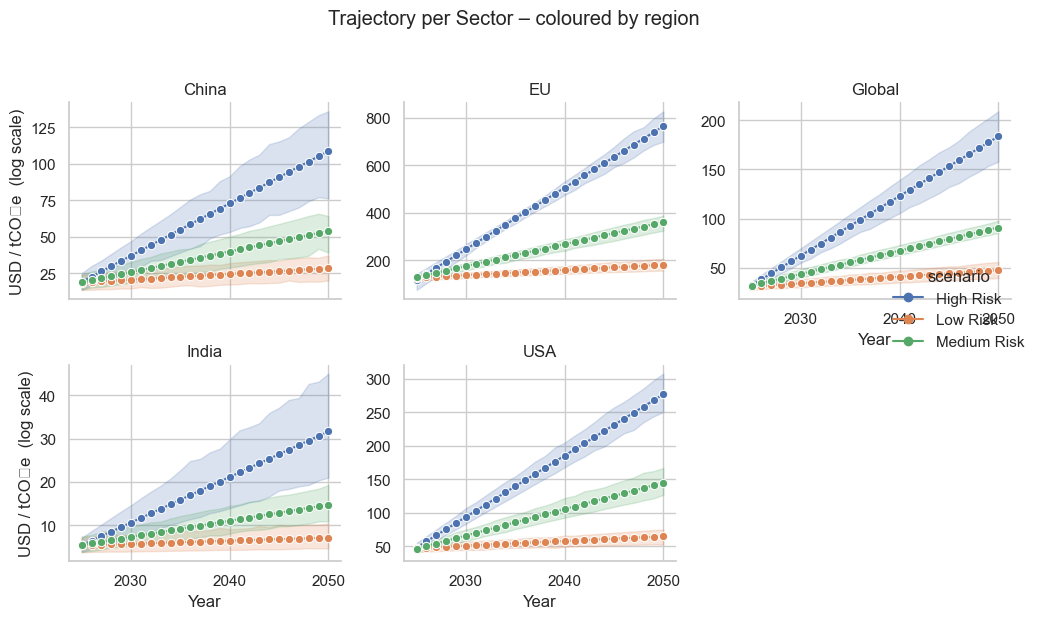

In [23]:
plot_df = carbon_prices_full.copy()
plot_df.loc[plot_df['carbon_price_usd_tco2e'] <= 0, 'carbon_price_usd_tco2e'] = np.nan

g = sns.relplot(
        data      = plot_df,
        x         = "year",
        y         = "carbon_price_usd_tco2e",
        hue       = "scenario",
        kind      = "line",
        marker    = "o",
        col       = "region",
        col_wrap  = 3,
        height    = 3,
        facet_kws = dict(sharey=False)
)

# put every facet on log-scale
for ax in g.axes.flatten():
    # ax.set_yscale('log')
    ax.yaxis.set_major_formatter(
        plt.FuncFormatter(lambda v, p: f"{v:g}")
    )

g.set_titles("{col_name}")
g.fig.suptitle("Trajectory per Sector – coloured by region", y=1.03)
g.set_axis_labels("Year", "USD / tCO₂e  (log scale)")
plt.tight_layout()
plt.show()

In [ ]:
# ngf5_global_carbon_prices

/opt/anaconda3/envs/sp_work/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



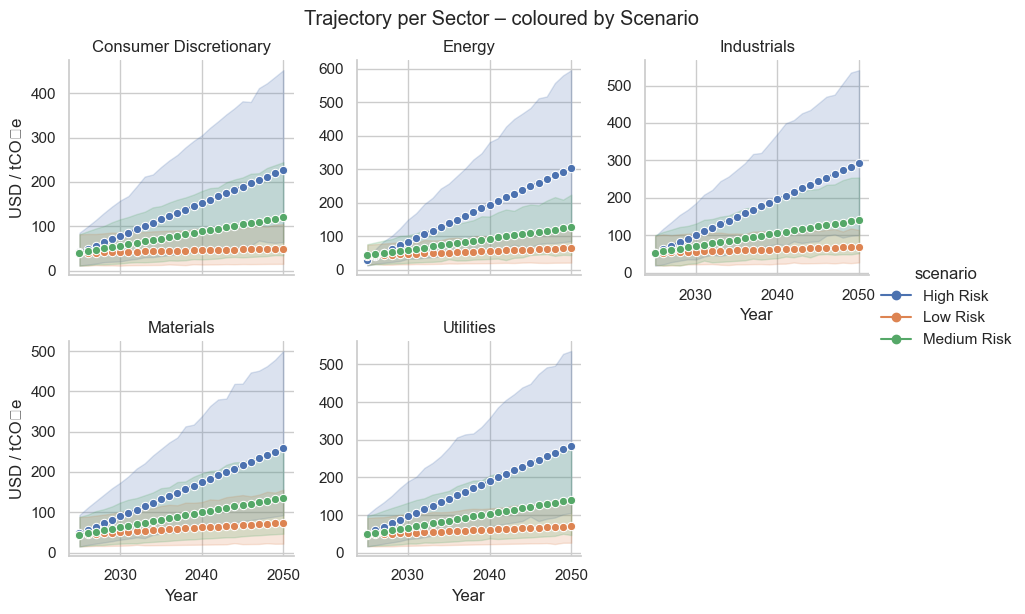

In [24]:
g = sns.relplot(
    data = carbon_prices_full,
    x="year", y="carbon_price_usd_tco2e",
    hue="scenario", kind="line", marker="o",
    col="sector", col_wrap=3, height=3, facet_kws={'sharey':False}
)
g.set_titles("{col_name}")
g.fig.suptitle("Trajectory per Sector – coloured by Scenario", y=1.02)
g.set_axis_labels("Year", "USD / tCO₂e")
plt.show()


In [ ]:
emissions_paths.head()

Estimate Abatement

In [25]:
"""
Abatement-cost engine  v1.1-lite
(c) 2025  –  delta-based capacity build / reuse
"""
from __future__ import annotations
import warnings
from typing import Dict, List, Tuple
import pandas as pd

# ────────────────────────────────────────────────────────────────
# 0.  Pathway filter
# ────────────────────────────────────────────────────────────────
def filter_paths(df: pd.DataFrame,
                 scenario: str = "low",
                 interp:   str = "linear",
                 verbose:  bool = True) -> pd.DataFrame:
    out = df.query("scenario == @scenario and interpolation_method == @interp").copy()
    if out.empty:
        raise ValueError("No rows for the chosen scenario / interpolation.")
    if verbose:
        print(f"⊢ Filtered to {len(out):,} rows  ({out['uid'].nunique()} companies)")
    return out


# ────────────────────────────────────────────────────────────────
# 1.  Technology filter
# ────────────────────────────────────────────────────────────────
def filter_tech_by_location_sector(df_abatement: pd.DataFrame,
                                   location: str,
                                   sector:   str) -> pd.DataFrame:
    tech = df_abatement[(df_abatement["sector"] == sector) &
                        (df_abatement["region"] == location)]
    if tech.empty:
        tech = df_abatement[(df_abatement["sector"] == sector) &
                            (df_abatement["region"] == "Global")]
    if tech.empty:
        tech = df_abatement[df_abatement["region"] == "Global"]
    if tech.empty:
        raise ValueError(f"No abatement tech for {sector=} {location=}.")
    return tech.copy()


# ────────────────────────────────────────────────────────────────
# 2.  Δ-tonnes needed this year
# ────────────────────────────────────────────────────────────────

def tonnes_to_abate(df_paths: pd.DataFrame,
                    uid: str,
                    year: int,
                    tgt: str,
                    prev_allowed: float | None) -> Tuple[float, float]:
    """
    tonnes_needed  =  allowed_{t-1}  –  allowed_{t}      ( ≥ 0 )
    allowed_now    =  Scope-1 / Scope-2 / (1+2) for year t
    """
    row = df_paths.query("uid == @uid and year == @year").iloc[0]

    # pick the right column(s)
    if tgt == "Scope 1":
        allowed_now = row["scope1_tonnes"]
    elif tgt == "Scope 2":
        allowed_now = row["scope2_tonnes"]
    else:                                   # Combined
        allowed_now = row["scope1_tonnes"] + row["scope2_tonnes"]

    # first model year: no reduction yet → Δ = 0
    if prev_allowed is None:
        tonnes_needed = 0.0
    else:
        tonnes_needed = max(prev_allowed - allowed_now, 0.0)

    return tonnes_needed, allowed_now


# ────────────────────────────────────────────────────────────────
# 3.  Dispatcher  – reuse spare → build cheapest new plants
# ────────────────────────────────────────────────────────────────
# ────────────────────────────────────────────────────────────────
# 3.  Dispatcher  – reuse installed capacity, build when needed
# ────────────────────────────────────────────────────────────────
def dispatch_with_capacity(tech_df: pd.DataFrame,
                           tonnes_needed: float,
                           capacity_bank: Dict[str, float]
                           ) -> tuple[list[dict], Dict[str, float]]:
    """
    Parameters
    ----------
    tech_df        : menu of abatement technologies allowed for this company
    tonnes_needed  : Δ-tonnes to abate in the current year
    capacity_bank  : {technology: total_installed_capacity}  (tCO₂e / yr)

    Returns
    -------
    packages       : list of build / reuse actions taken this year
    capacity_bank  : updated bank for next year
    """
    packages: list[dict] = []

    # ----------------------------------------------------------- #
    # 1️⃣  Re-use capacity already installed in previous years
    # ----------------------------------------------------------- #
    for tech, cap in capacity_bank.items():
        if tonnes_needed <= 0:
            break
        take = min(cap, tonnes_needed)          # can’t exceed rated capacity
        if take > 0:
            r     = tech_df.loc[tech_df["technology"] == tech].iloc[0]
            opex  = r["abatement_cost_usd_tco2e_year"] * take
            packages.append({
                "technology": tech,
                "new_build":  False,
                "tonnes":     take,
                "plant_capacity": cap,          # full rated capacity
                "capex_usd":  0.0,
                "opex_usd_year": opex,
                "cost_per_tonne_abated": opex / take,
                "abatement_tech_sector": r["sector"],
            })
            tonnes_needed -= take               # capacity is re-usable next year

    # ----------------------------------------------------------- #
    # 2️⃣  Build new plants (cheapest first) if demand still unmet
    # ----------------------------------------------------------- #
    if tonnes_needed > 0:
        tech_df = tech_df.assign(
            levelised=(tech_df["initial_investment_usd_million"] * 1e6
                       / tech_df["abatement_capacity_tco2e_year"]
                       + tech_df["abatement_cost_usd_tco2e_year"])
        ).sort_values("levelised")

        for _, r in tech_df.iterrows():
            if tonnes_needed <= 0:
                break

            cap   = r["abatement_capacity_tco2e_year"]
            take  = min(cap, tonnes_needed)
            capex = r["initial_investment_usd_million"] * 1e6
            opex  = r["abatement_cost_usd_tco2e_year"] * take

            packages.append({
                "technology": r["technology"],
                "new_build":  True,
                "tonnes":     take,
                "plant_capacity": cap,
                "capex_usd":  capex,
                "opex_usd_year": opex,
                "cost_per_tonne_abated": (capex / cap) + r["abatement_cost_usd_tco2e_year"],
                "abatement_tech_sector": r["sector"],
            })

            # add the new plant’s capacity to any that already exists
            capacity_bank[r["technology"]] = capacity_bank.get(r["technology"], 0) + cap
            tonnes_needed -= take

    return packages, capacity_bank



# ────────────────────────────────────────────────────────────────
# 4.  Per-company engine
# ────────────────────────────────────────────────────────────────
TARGET_MAP = {
    "Scope 1":            "Scope 1",
    "Scope 2":            "Scope 2",
    "Direct":             "Combined",
    "Scope 2 and other":  "Combined",
}

def compute_company_abatement_costs(uid: str,
                                    df_paths: pd.DataFrame,
                                    df_abatement: pd.DataFrame
                                    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    comp = df_paths[df_paths["uid"] == uid]
    if comp.empty:
        raise ValueError(f"{uid=} missing in pathway data.")

    raw_tgt = comp["type_of_target"].iat[0]
    if raw_tgt == "Scope 3":
        warnings.warn(f"Skipping {uid}: Scope 3 target (not modelled).")
        return pd.DataFrame(), pd.DataFrame()

    tgt = TARGET_MAP.get(raw_tgt)
    if tgt is None:
        warnings.warn(f"Skipping {uid}: unknown target '{raw_tgt}'.")
        return pd.DataFrame(), pd.DataFrame()

    sector   = comp["gics_sector"].iat[0]
    location = comp["country"].iat[0]
    tech_df  = filter_tech_by_location_sector(df_abatement, location, sector)

    capacity_bank: Dict[str, float] = {}
    annual_rows:  List[dict] = []
    detail_rows:  List[dict] = []
    cum_capex = cum_opex = 0.0
    prev_allowed: float | None = None

    for year in sorted(comp["year"].unique()):
        tonnes_needed, allowed_now = tonnes_to_abate(df_paths, uid, year, tgt, prev_allowed)
        packages, capacity_bank = dispatch_with_capacity(tech_df, tonnes_needed, capacity_bank)

        capex = sum(p["capex_usd"]     for p in packages)
        opex  = sum(p["opex_usd_year"] for p in packages)
        cum_capex += capex
        cum_opex  += opex

        annual_rows.append({
            "uid": uid, "year": year, "region": location, "gics_sector": sector,
            "abatement_tonnes": tonnes_needed,
            "capex_usd": capex, "opex_usd_year": opex,
            "cum_capex_usd": cum_capex, "cum_opex_usd": cum_opex,
            "technology_used": "; ".join(p["technology"] for p in packages),
            "plant_capacity_built_this_year": sum(
                p["plant_capacity"] for p in packages if p["new_build"]),
        })

        for p in packages:
            detail_rows.append({**p, "uid": uid, "year": year,
                                "region": location, "gics_sector": sector})

        prev_allowed = allowed_now

    return pd.DataFrame(annual_rows), pd.DataFrame(detail_rows)


# ────────────────────────────────────────────────────────────────
# 5.  Portfolio runner
# ────────────────────────────────────────────────────────────────
def run_all_companies(df_paths: pd.DataFrame,
                      df_abatement: pd.DataFrame
                      ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    annual_frames, detail_frames = [], []
    for uid in df_paths["uid"].unique():
        annual, detail = compute_company_abatement_costs(uid, df_paths, df_abatement)
        if not annual.empty:
            annual_frames.append(annual)
            detail_frames.append(detail)

    if not annual_frames:
        raise ValueError("No company produced output – check target labels.")

    annual_df = pd.concat(annual_frames, ignore_index=True)
    detail_df = pd.concat(detail_frames, ignore_index=True)
    summary_df = (annual_df.groupby("uid")
                  .agg(total_capex_usd     = ("capex_usd", "sum"),
                       total_opex_usd      = ("opex_usd_year", "sum"),
                       total_abated_tonnes = ("abatement_tonnes", "sum"),
                       region              = ("region", "first"),
                       gics_sector         = ("gics_sector", "first"))
                  .reset_index())
    return annual_df, summary_df, detail_df


# ────────────────────────────────────────────────────────────────
# 6.  Example (comment out SystemExit when real data are loaded)
# ────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # raise SystemExit(
    #     "Load `emissions_paths` & `df_abatement`, then:\n")
        paths = filter_paths(emissions_paths, 'low', 'linear')
        annual_df, summary_df, detail_df = run_all_companies(paths, df_abatement)
        annual_df.to_csv('annual_abatement_costs.csv', index=False)
        summary_df.to_csv('summary_abatement_costs.csv', index=False)
        detail_df.to_csv('detail_abatement_costs.csv', index=False)
    


⊢ Filtered to 1,196 rows  (45 companies)


In [23]:
emissions_paths.head()

,uid,gics_sector,country,type_of_target,year,scope1_tonnes,scope2_tonnes,targeted_emissions,scenario,growth_rate,interpolation_method
0,C001,Real Estate,Global,Scope 2,2025,21510000,1070000,1070000,low,0.0,linear
1,C001,Real Estate,Global,Scope 2,2026,21510000,1046588,1046588,low,0.0,linear
2,C001,Real Estate,Global,Scope 2,2027,21510000,1023177,1023177,low,0.0,linear
3,C001,Real Estate,Global,Scope 2,2028,21510000,999765,999765,low,0.0,linear
4,C001,Real Estate,Global,Scope 2,2029,21510000,976354,976354,low,0.0,linear


In [17]:
df_abatement.head()

,sector,region,technology,initial_investment_usd_million,abatement_capacity_tco2e_year,abatement_cost_usd_tco2e_year
0,Energy,USA,Utility-scale Solar,350.52,60952,50.97
1,Energy,USA,Wind Power,218.94,192720,31.15
2,Energy,EU,Utility-scale Solar,558.64,54776,44.22
3,Energy,EU,Carbon Capture and Storage,340.98,50000,105.16
4,Energy,China,Utility-scale Solar,380.28,217543,43.47


In [24]:
annual_df.head()# emissions_paths.head()

,uid,year,region,gics_sector,abatement_tonnes,capex_usd,opex_usd_year,cum_capex_usd,cum_opex_usd,technology_used,plant_capacity_built_this_year
0,C001,2025,Global,Real Estate,0.0,0.0,0.00,0.0,0.00,,0
1,C001,2026,Global,Real Estate,23412.0,77400000.0,1101066.36,77400000.0,1101066.36,Energy Efficiency Upgrades,39466
2,C001,2027,Global,Real Estate,23411.0,0.0,1101019.33,77400000.0,2202085.69,Energy Efficiency Upgrades,0
3,C001,2028,Global,Real Estate,23412.0,0.0,1101066.36,77400000.0,3303152.05,Energy Efficiency Upgrades,0
4,C001,2029,Global,Real Estate,23411.0,0.0,1101019.33,77400000.0,4404171.38,Energy Efficiency Upgrades,0


trade off analysis.

In [ ]:


def build_tradeoff_table(annual_df, emissions_paths, carbon_prices_full):
    # ── 1. Merge emissions + abatement ────────────────────────────────
    emis = (emissions_paths
            .assign(e_total=lambda d: d['scope1_tonnes'] + d['scope2_tonnes'])
            .loc[:, ['uid', 'year', 'gics_sector', 'country', 'e_total']])

    abat = (annual_df
            .loc[:, ['uid', 'year',
                     'abatement_tonnes', 'capex_usd', 'opex_usd_year']]
            .sort_values(['uid', 'year'])
            .assign(capex_cum=lambda d: d.groupby('uid')['capex_usd'].cumsum(),
                    opex_cum =lambda d: d.groupby('uid')['opex_usd_year'].cumsum()))

    base = emis.merge(abat, on=['uid', 'year'], how='left').fillna(0)

    # ── 2. Cross-join every scenario (Low / Medium / High) ────────────
    scenarios = carbon_prices_full['scenario'].unique()
    base = (base.assign(key=1)
                 .merge(pd.DataFrame({'scenario': scenarios, 'key': 1}),
                        on='key').drop('key', axis=1))

    # ── 3. Attach carbon prices with Global fallback ──────────────────
    price_cols = ['sector', 'region', 'scenario',
                  'year', 'carbon_price_usd_tco2e']
    prices = carbon_prices_full[price_cols]

    df = base.merge(
        prices,
        left_on =['gics_sector','country','scenario','year'],
        right_on=['sector'     ,'region' ,'scenario','year'],
        how='left')

    miss = df['carbon_price_usd_tco2e'].isna()
    if miss.any():
        global_prices = prices[prices['region'] == 'Global']
        df.loc[miss, 'carbon_price_usd_tco2e'] = (
            df[miss]
            .merge(global_prices,
                   on=['sector','scenario','year'],
                   how='left')['carbon_price_usd_tco2e_y']
        )

    # ── 4. Compute cost metrics ───────────────────────────────────────
    df['carbon_cost_without_usd'] = df['e_total'] * df['carbon_price_usd_tco2e']
    df['carbon_cost_with_usd']    = (
        (df['e_total'] - df['abatement_tonnes']) *
        df['carbon_price_usd_tco2e']
    )
    df['total_cost_with_abatement_usd'] = (
        df['capex_cum'] + df['opex_cum'] + df['carbon_cost_with_usd']
    )
    df['net_savings_usd'] = (
        df['carbon_cost_without_usd'] - df['total_cost_with_abatement_usd']
    )

    return df[['uid','scenario','year',
               'carbon_cost_without_usd',
               'total_cost_with_abatement_usd',
               'net_savings_usd']]

tradeoffs = build_tradeoff_table(annual_df, emissions_paths, carbon_prices_full)

# ── Export the tradeoff table ───────────────────────────────────────
tradeoffs.to_csv("tradeoff_table.csv", index=False)


In [ ]:
# tradeoffs.head()